# **Project "*Medical Insurance Cost Prediction*"**

In [ ]:
Image('/Users/alexangelbracho/Desktop/projectAWS/images/imageInsurance.jpeg') 

# **1. Overview**






### The medical insurance is one of the most important issues of any society. Therefore, the costs associated with this is very critical in any familiar budget. In this project, we´ll be dealing with two main questions:

### **--->** What are the primary factors influencing medical insurance expenses?

### **--->** How accurate is the Linear Regression machine learning technique in predicting medical expenses?

## *Core Question*

### **What is the estimated cost of a Medical Insurance?**


# **2. Preprocessing**

In [3]:
# data and array managament
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Image
%matplotlib inline

# sckikit-learn libraries
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pickle

# spark libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from boto3.session import Session

## **2.1 Data Cleaning**

### We´ll use Spark to make this section.


In [4]:
# Create the Spark Session

spark = SparkSession.builder.appName('sparkInsurance').getOrCreate()

spark

24/04/15 20:19:19 WARN Utils: Your hostname, Alexangels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.12 instead (on interface en0)
24/04/15 20:19:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/15 20:19:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [97]:
# Create the table 

insurance_df = spark.read.csv('./file_csv/medical_insurance.csv', sep=',', header=True)

insurance_df.show(5)


print(insurance_df.count())

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|    33|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows

2772


In [98]:
insurance_df.count()

2772

In [99]:
## Drop Duplicates

insurance_df = insurance_df.dropDuplicates()

In [101]:
insurance_df.count()

1338

In [102]:
## Drop Null values

insurance_df = insurance_df.na.drop(how='any')

In [103]:
insurance_df.count()

1338

### There were no null values in the dataset.

In [104]:
# rename the column 'bmi' by 'body_mass_index'

insurance_df = insurance_df.withColumnsRenamed({'bmi':'body_mass_index'})

In [105]:
insurance_df.show(3)

+---+------+---------------+--------+------+---------+----------+
|age|   sex|body_mass_index|children|smoker|   region|   charges|
+---+------+---------------+--------+------+---------+----------+
| 43|  male|          27.36|       3|    no|northeast| 8606.2174|
| 48|  male|          24.42|       0|   yes|southeast|21223.6758|
| 20|female|          26.84|       1|   yes|southeast|17085.2676|
+---+------+---------------+--------+------+---------+----------+
only showing top 3 rows



In [106]:
# here, we have the charges in ascending order 
insurance_df.sort('charges')[['charges']].show()

+-----------+
|    charges|
+-----------+
|  10043.249|
|  10065.413|
|10072.05505|
|  10085.846|
|   10096.97|
|10106.13425|
| 10107.2206|
|10115.00885|
|  10118.424|
| 10141.1362|
| 10156.7832|
| 10197.7722|
|  10214.636|
| 10226.2842|
| 10231.4999|
| 10264.4421|
|   10269.46|
|  10325.206|
| 10338.9316|
|  10355.641|
+-----------+
only showing top 20 rows



In [107]:
## 5. Apply filters :
## charges & smoker

insurance_df_filter = insurance_df.filter((insurance_df.charges > 35000) & (insurance_df.smoker == 'yes' ) )
insurance_df_filter.show()
print(f'The number of people who smoke and spend more than $35.000:',insurance_df_filter.count())

+---+------+---------------+--------+------+---------+-----------+
|age|   sex|body_mass_index|children|smoker|   region|    charges|
+---+------+---------------+--------+------+---------+-----------+
| 64|  male|          33.88|       0|   yes|southeast| 46889.2612|
| 48|  male|         40.565|       2|   yes|northwest|45702.02235|
| 51|female|          34.96|       2|   yes|northeast| 44641.1974|
| 31|  male|          34.39|       3|   yes|northwest| 38746.3551|
| 57|female|          31.16|       0|   yes|northwest| 43578.9394|
| 23|female|          42.75|       1|   yes|northeast| 40904.1995|
| 37|  male|           34.2|       1|   yes|northeast|  39047.285|
| 25|  male|          33.33|       2|   yes|southeast| 36124.5737|
| 51|female|          38.06|       0|   yes|southeast| 44400.4064|
| 38|  male|          38.39|       3|   yes|southeast| 41949.2441|
| 53|  male|         34.105|       0|   yes|northeast|43254.41795|
| 30|  male|           37.8|       2|   yes|southwest|  39241.

In [108]:
insurance_df_filter = insurance_df.filter((insurance_df.charges > 35000) & (insurance_df.smoker == 'no' ) )
insurance_df_filter.show()
print(f'The number of people who don´t smoke and spend more than $35.000:',insurance_df_filter.count())

+---+------+---------------+--------+------+---------+-----------+
|age|   sex|body_mass_index|children|smoker|   region|    charges|
+---+------+---------------+--------+------+---------+-----------+
| 61|female|          33.33|       4|    no|southeast|36580.28216|
| 55|female|           26.8|       1|    no|southwest|35160.13457|
| 59|female|           34.8|       2|    no|southwest|36910.60803|
+---+------+---------------+--------+------+---------+-----------+

The number of people who don´t smoke and spend more than $35.000: 3


### From the previous data, we can see that there are 274 people who are smokers paying more than $35.000 in insurance versus 6 not being.

In [109]:
## 6. Number of classes per feature
## smoker

insurance_df[['smoker']].distinct().show()
print('The number of classes here is:',insurance_df[['smoker']].distinct().count())

+------+
|smoker|
+------+
|    no|
|   yes|
+------+

The number of classes here is: 2


In [110]:
## region

insurance_df[['region']].distinct().show()
print('The number of classes here is:',insurance_df[['region']].distinct().count())

+---------+
|   region|
+---------+
|northwest|
|southeast|
|northeast|
|southwest|
+---------+

The number of classes here is: 4


In [111]:
## age

insurance_df[['age']].distinct().show()
print('The number of classes here is:',insurance_df[['age']].distinct().count())

+---+
|age|
+---+
| 51|
| 54|
| 29|
| 42|
| 64|
| 30|
| 34|
| 59|
| 28|
| 22|
| 52|
| 35|
| 47|
| 43|
| 31|
| 18|
| 27|
| 61|
| 26|
| 46|
+---+
only showing top 20 rows

The number of classes here is: 47


In [112]:
## children

insurance_df[['children']].distinct().show()
print('The number of classes here is:',insurance_df[['children']].distinct().count())

+--------+
|children|
+--------+
|       3|
|       0|
|       5|
|       1|
|       4|
|       2|
+--------+

The number of classes here is: 6


In [113]:
## sex

insurance_df[['sex']].distinct().show()
print('The number of classes here is:',insurance_df[['sex']].distinct().count())

+------+
|   sex|
+------+
|female|
|  male|
+------+

The number of classes here is: 2


In [114]:
## smoker

insurance_df[['smoker']].distinct().show()
print('The number of classes here is:',insurance_df[['smoker']].distinct().count())

+------+
|smoker|
+------+
|    no|
|   yes|
+------+

The number of classes here is: 2


In [115]:
## charges

insurance_df[['charges']].distinct().show()
print('The number of classes here is:',insurance_df[['charges']].distinct().count())

+-----------+
|    charges|
+-----------+
| 2198.18985|
|  2134.9015|
| 15359.1045|
|  5594.8455|
| 9095.06825|
| 2709.24395|
| 10594.2257|
| 17663.1442|
|  7731.4271|
|7323.734819|
| 15817.9857|
| 29523.1656|
|  8428.0693|
| 36307.7983|
|  6289.7549|
|19673.33573|
| 5373.36425|
|  4058.1161|
|  1135.9407|
|   2597.779|
+-----------+
only showing top 20 rows

The number of classes here is: 1338


In [116]:
insurance_df.show(5)

+---+------+---------------+--------+------+---------+----------+
|age|   sex|body_mass_index|children|smoker|   region|   charges|
+---+------+---------------+--------+------+---------+----------+
| 43|  male|          27.36|       3|    no|northeast| 8606.2174|
| 48|  male|          24.42|       0|   yes|southeast|21223.6758|
| 20|female|          26.84|       1|   yes|southeast|17085.2676|
| 47|female|         29.545|       1|    no|northwest|8930.93455|
| 36|female|          30.02|       0|    no|northwest| 5272.1758|
+---+------+---------------+--------+------+---------+----------+
only showing top 5 rows



In [117]:
insurance_df.count()

1338

In [118]:
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

insurance_df_pd = insurance_df.toPandas()

In [119]:
insurance_df_pd.count()

age                1338
sex                1338
body_mass_index    1338
children           1338
smoker             1338
region             1338
charges            1338
dtype: int64

## **2.2 Data Coding**

#### In this part, we´ll perform some ***data coding*** from the file preprocessed in the previous step with Spark.

In [120]:
insurance_df_pd.head(10)

,age,sex,body_mass_index,children,smoker,region,charges
0,43,male,27.36,3,no,northeast,8606.2174
1,48,male,24.42,0,yes,southeast,21223.6758
2,20,female,26.84,1,yes,southeast,17085.2676
3,47,female,29.545,1,no,northwest,8930.93455
4,36,female,30.02,0,no,northwest,5272.1758
5,19,male,19.8,0,no,southwest,1241.565
6,29,female,21.85,0,yes,northeast,16115.3045
7,61,female,39.1,2,no,southwest,14235.072
8,42,female,26.6,0,yes,northwest,21348.706
9,18,female,26.73,0,no,southeast,1615.7667


### Now, we´ll use the describe method to check some properties of the dataset.

In [121]:
insurance_df_pd.describe()

,age,sex,body_mass_index,children,smoker,region,charges
count,1338,1338,1338,1338,1338,1338,1338
unique,47,2,548,6,2,4,1338
top,18,male,32.3,0,no,southeast,8606.2174
freq,69,676,13,574,1064,364,1


### And then, some general info about the dataset. 

In [122]:
insurance_df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              1338 non-null   object
 1   sex              1338 non-null   object
 2   body_mass_index  1338 non-null   object
 3   children         1338 non-null   object
 4   smoker           1338 non-null   object
 5   region           1338 non-null   object
 6   charges          1338 non-null   object
dtypes: object(7)
memory usage: 73.3+ KB


### We can see there are three non-numerical variables: *sex,smoker and region*. We´ll "code" them. We´ll use the method of Scikit-learn named *LabelEncoder()*.

In [126]:
# sex

encoder = preprocessing.LabelEncoder()

insurance_df_pd['sex']= encoder.fit_transform(insurance_df_pd['sex'])

insurance_df_pd['sex']

0       1
1       1
2       0
3       0
4       0
       ..
1333    1
1334    0
1335    0
1336    1
1337    0
Name: sex, Length: 1338, dtype: int64

In [127]:
# smoker

encoder = preprocessing.LabelEncoder()

insurance_df_pd['smoker']= encoder.fit_transform(insurance_df_pd['smoker'])

insurance_df_pd['smoker']

0       0
1       1
2       1
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    1
1337    0
Name: smoker, Length: 1338, dtype: int64

In [128]:
# region

encoder = preprocessing.LabelEncoder()

insurance_df_pd['region']= encoder.fit_transform(insurance_df_pd['region'])

insurance_df_pd['region']

0       0
1       2
2       2
3       1
4       1
       ..
1333    0
1334    3
1335    1
1336    2
1337    2
Name: region, Length: 1338, dtype: int64

#### Now, we´ve done the *data coding* we can take a glance at how the dataset looks like right now.

In [129]:
insurance_df_pd.head(5)

,age,sex,body_mass_index,children,smoker,region,charges
0,43,1,27.36,3,0,0,8606.2174
1,48,1,24.42,0,1,2,21223.6758
2,20,0,26.84,1,1,2,17085.2676
3,47,0,29.545,1,0,1,8930.93455
4,36,0,30.02,0,0,1,5272.1758


### We can see there are no categorical (non-numerical) values. Now, let´s take a look at the other library: Seaborn. We need to do further analysis with the heat map and the Pearson´s correlation matrix with all the variables to establish some relation between them (if there is some).

# **3. EDA (Exploratory Data Analysis)**

## **3.1 Visualization**

In [156]:
insurance_df_pd.head(2)

,age,sex,body_mass_index,children,smoker,region,charges
0,43,1,27.36,3,0,0,8606.2174
1,48,1,24.42,0,1,2,21223.6758


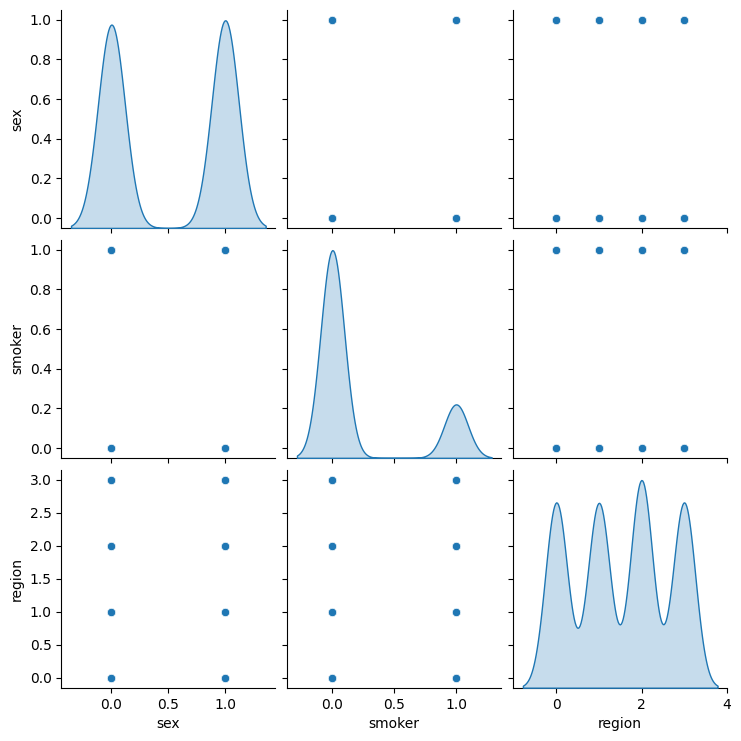

In [157]:
sb.pairplot(insurance_df_pd[['age', 'sex', 'body_mass_index', 'children', 'smoker', 'region', 'charges']], diag_kind='kde')

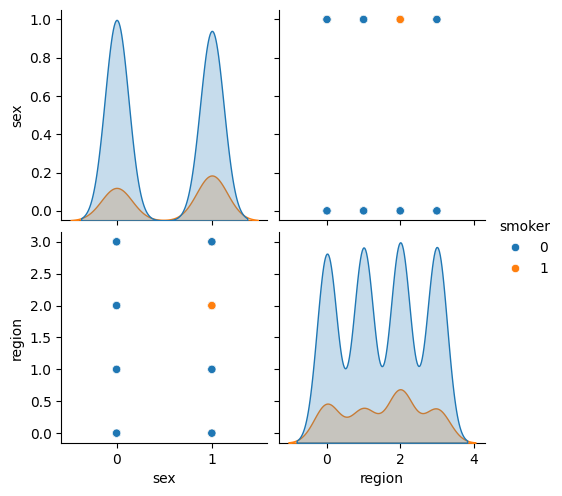

In [158]:
sb.pairplot(insurance_df_pd[['age', 'sex', 'body_mass_index', 'children', 'smoker', 'region', 'charges']], hue='smoker')

### We can see that the sex feature is balanced as well the region. On the other hand, we´ll find out how is the correlation between the variables in the dataset. Firstly, let´s see the *heatmap*.

<Axes: >

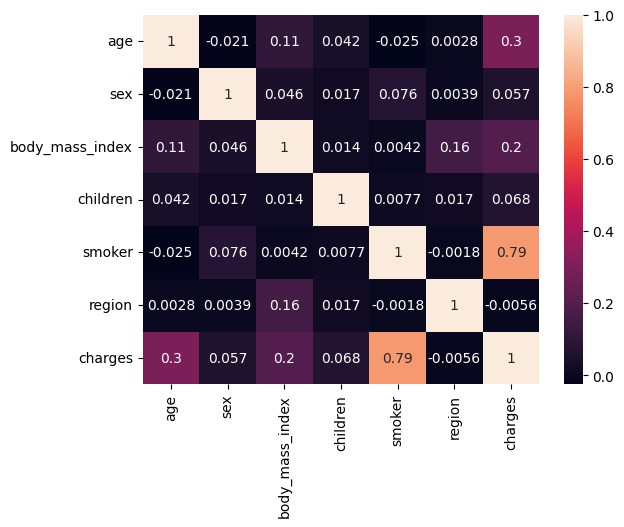

In [155]:
# heatmap

sb.heatmap(insurance_df_pd[['age', 'sex', 'body_mass_index', 'children', 'smoker', 'region', 'charges']].corr(),annot = True)

### From the Perason´s correlation we can see that the variables that are more related are "smoker" (feature) and "charges" (labels) with a number of 0,79 (the maximum possible value is 1). Moreover, we can see the correlation of all the variables with the target ('charges').

In [131]:
corr_matrix = insurance_df_pd.corr()
corr_matrix

,age,sex,body_mass_index,children,smoker,region,charges
age,1.000000,-0.020651,0.110203,0.042287,-0.025134,0.002808,0.298845
sex,-0.020651,1.000000,0.045532,0.017163,0.076185,0.003916,0.057341
body_mass_index,0.110203,0.045532,1.000000,0.013504,0.004168,0.158536,0.198999
children,0.042287,0.017163,0.013504,1.000000,0.007673,0.017174,0.067959
smoker,-0.025134,0.076185,0.004168,0.007673,1.000000,-0.001836,0.787262
region,0.002808,0.003916,0.158536,0.017174,-0.001836,1.000000,-0.005619
charges,0.298845,0.057341,0.198999,0.067959,0.787262,-0.005619,1.000000


#### Moreover, we can see the correlation of all the variables with the label ('charges').

In [132]:
corr_matrix['charges'].sort_values(ascending=False)

charges            1.000000
smoker             0.787262
age                0.298845
body_mass_index    0.198999
children           0.067959
sex                0.057341
region            -0.005619
Name: charges, dtype: float64

#### Once again, we see the closest relation is between smoker and charges. This will be useful for the selection of the attributes.

## **3.2 Selection of the attributes**

In [133]:
X = insurance_df_pd['smoker']   ## X

Y = insurance_df_pd['charges']   ## Y

In [134]:
X.shape

(1338,)

In [135]:
Y.shape

(1338,)

In [136]:
X_smoker = np.array(X).reshape(-1,1)
Y_charges = np.array(Y).reshape(-1,1)

print(X_smoker.shape)
print(Y_charges.shape)

(1338, 1)
(1338, 1)


##  **3.3 Train/Test/Val split**

In [137]:
X_train,X_val, Y_train, Y_val = train_test_split(X_smoker,Y_charges, test_size=0.2)

In [138]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(1070, 1)
(268, 1)
(1070, 1)
(268, 1)


## **3.4 Scaler**

In [139]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

In [140]:
X_train

array([[ 1.99417757],
       [-0.50145986],
       [ 1.99417757],
       ...,
       [-0.50145986],
       [-0.50145986],
       [-0.50145986]])

In [141]:
Y_train

array([['34672.1472'],
       ['28287.89766'],
       ['42112.2356'],
       ...,
       ['3594.17085'],
       ['12815.44495'],
       ['1842.519']], dtype=object)

In [142]:
X_val = scaler.transform(X_val)

# **4. Training of the model**

### We´ll use the *Linear Regression* algorithm because we need to find a continous values, that is, the cost of a medical insurance.

## **4.1 Training the model**

In [143]:
# here, we fix the model as Linear Regression

model = sklearn.linear_model.LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

## **4.2 Predictions of the model**

In [144]:
print(X_val.shape)
Y_pred = model.predict(X_val)
print(Y_pred.shape)
print(Y_pred)

(268, 1)
(268, 1)
[[ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [31833.68590177]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23464463]
 [ 8336.23

In [145]:
list_of_predictions = pd.DataFrame(Y_pred)

In [146]:
list_of_predictions.head(5)

,0
0,8336.234645
1,8336.234645
2,31833.685902
3,8336.234645
4,8336.234645


## **4.3 Evaluation of the model**

### In the *Linear Regression* machine learning algorithm, we use *metrics* to calculate an error to summarize the predictive skill of a model. There are several sort of errors we could use, for instance,

**---->** *Mean Squared Error*

**---->** R^2 coefficient

**---->** *Root Mean Squared Error*

**---->** *Mean Absolute Error*

### Among them, we´ll use the *Mean Square Error* because of the fact that this one is less suitable to outliers. 

### **4.3.1** ***Mean Squared Error***

In [147]:
# Mean Abosulte Error (MAE)
# here, we´ll use the library of SciKit-learn

errors = sklearn.metrics.mean_absolute_error(Y_val,Y_pred)

In [148]:
print('The standard deviation is: $',errors)

The standard deviation is: $ 6069.953299581332


#### It means that there might be an error or difference of $6069 when the prediction is done. 

### **4.3.2** ***R^2 coefficient***

In [149]:
# R2 coefficient

r2_coefficient = r2_score(Y_val,Y_pred)
print('The R^2 coefficient is:',r2_coefficient)


The R^2 coefficient is: 0.606841474855641


#### It means that the models will predict correctly the cost of the medical insurance 60 times every 100 persons. 

# **5. Storage**

## **5.1 Model**

In [159]:
def saveModel(name_model):
  #name = name_model
  model_file = f"{name_model}" + ".pkl"

  with open(model_file,'wb') as f:
      pickle.dump(name_model,f)

In [160]:
saveModel(model)

## **5.2 Scaler**

In [161]:
def saveScaler(name_scaler):

  scaler_file = f'{name_scaler}'+'.pkl'

  with open(scaler_file,'wb') as f:
      pickle.dump(scaler,f)


In [162]:
saveScaler(scaler)